## Copyright [2025] [Indian Institute of Science, Bangaluru]
## SPDX-License-Identifier: Apache-2.0

## Experiment 5 : Dynamic rate control simulation in an 802.11ac channel

### *1. Learning objectives*

• To create a single user (SU) very high throughput (VHT) format configuration object and initialize the
transmit parameters for IEEE 802.11ac standard.

• To configure a TGac channel of 40 MHz bandwidth using  wlanTGacChannel system object.

• To pass the transmit waveform through the TGac channel and add AWGN to the transmit waveform.

• Receiver processing, and SNR estimation at the receiver.

• To select MCS (modulation and coding scheme) based on the SNR estimate.


### *2. Introduction*

The IEEE 802.11 standard supports dynamic rate control by adjusting the Modulation and Coding Scheme (MCS) for each transmitted packet.

The wireless propagation channel, affected by multipath fading and mobility of surrounding objects, varies over time, requiring MCS adjustments to maximize link throughput.

The standard does not define a specific Rate Control Algorithm (RCA), so manufacturers are free to implement their own schemes for varying the MCS.

A closed-loop rate control method is commonly used, where the receiver calculates the recommended MCS, and this information is conveyed to the transmitter without significant feedback delay.

MCS is dynamically adjusted for each packet to respond to evolving channel conditions, ensuring efficient data transmission despite variations in noise power.

In a practical system, the MCS adjustment is typically communicated via control frames, although this exchange introduces some feedback latency.

The MCS adjustment algorithm works by monitoring various parameters such as Signal-to-Noise Ratio (SNR), packet error rates, and throughput to decide when to increase or decrease the transmission rate.


#### • 802.11 Dynamic Rate Control Simulation

<div style="text-align: center;">
    <p><strong>Dynamic Rate Control Simulation</strong></p>
    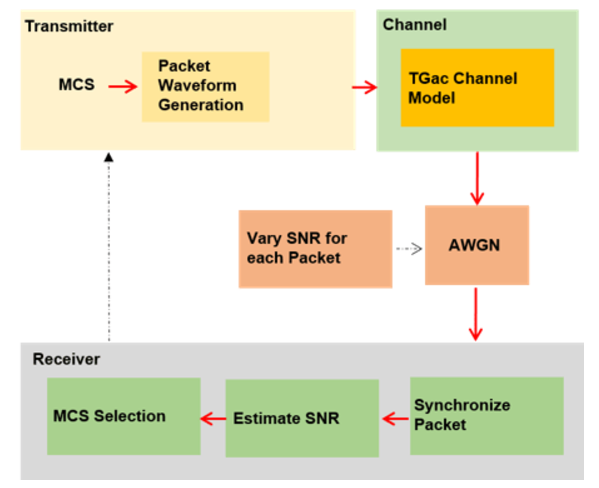
</div>


### Processing Steps

- **PSDU Creation and Encoding**: A Packet Service Data Unit (PSDU) is generated, consisting of data bits that are encoded (using channel coding like LDPC or convolutional coding) to create a modulated signal suitable for transmission.
  
- **Idle Time Addition**: A fixed idle time (e.g., 0.5 ms) is added between successive packets to avoid overlap and ensure the receiver can process the current packet before the next one arrives.

- **Channel Processing (TGac Model)**: The generated packet waveform is passed through a fading channel model (TGac channel), which simulates real-world impairments such as multi-path fading and Doppler shifts due to motion.

- **AWGN Addition**: Additive White Gaussian Noise (AWGN) is added to the transmitted signal to simulate noise in the communication channel. The noise power is adjusted to ensure the desired Signal-to-Noise Ratio (SNR) per subcarrier after OFDM demodulation.

- **Receiver Processing and SNR Estimation**: At the receiver, the signal undergoes processing steps such as synchronization, OFDM demodulation, and SNR estimation. The receiver estimates the SNR for each packet based on the received signal and noise power.

- **VHT-LTF Extraction and Channel Estimation**: The VHT-LTF (Very High Throughput-LTF) field is extracted from the received waveform. This field is used for fine timing synchronization and channel estimation. The LTF symbols are demodulated to estimate the channel response.

- **VHT Data Extraction**: The data field (VHT Data) is extracted from the synchronized waveform. This field contains the payload and is crucial for recovering the original PSDU.

- **Noise Estimation**: Noise variance is estimated using the pilot subcarriers in the demodulated VHT Data field and single-stream channel estimates. This helps determine the noise power, essential for SNR estimation.

- **MCS Adjustment Based on SNR**: The receiver compares the estimated SNR with predefined thresholds to adjust the Modulation and Coding Scheme (MCS). If the SNR is above a threshold, a higher MCS is chosen; if it is below, a lower MCS is selected to improve reliability.

- **PSDU Recovery**: Using the VHT Data field and the channel estimates, the receiver recovers the transmitted PSDU by performing demodulation and decoding operations.

### Assumptions

- Fixed bandwidth and antenna configuration for each packet.
- No explicit feedback for MCS; the transmitter uses pre-known MCS values for subsequent packets.
- A fixed idle time of 0.5 ms between packets.



#### • Processing Chain

### *3. Results*

<div style="text-align: center;">
    <p><strong>Constellation</strong></p>
    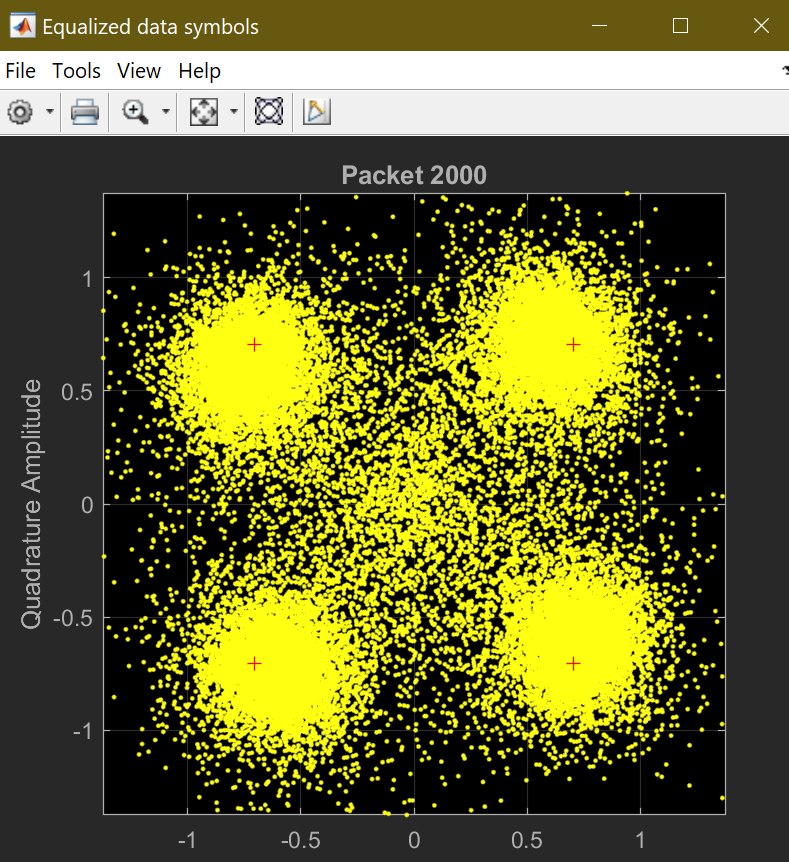
</div>


<div style="text-align: center;">
    <p><strong>Output constant snrwalk </strong></p>
    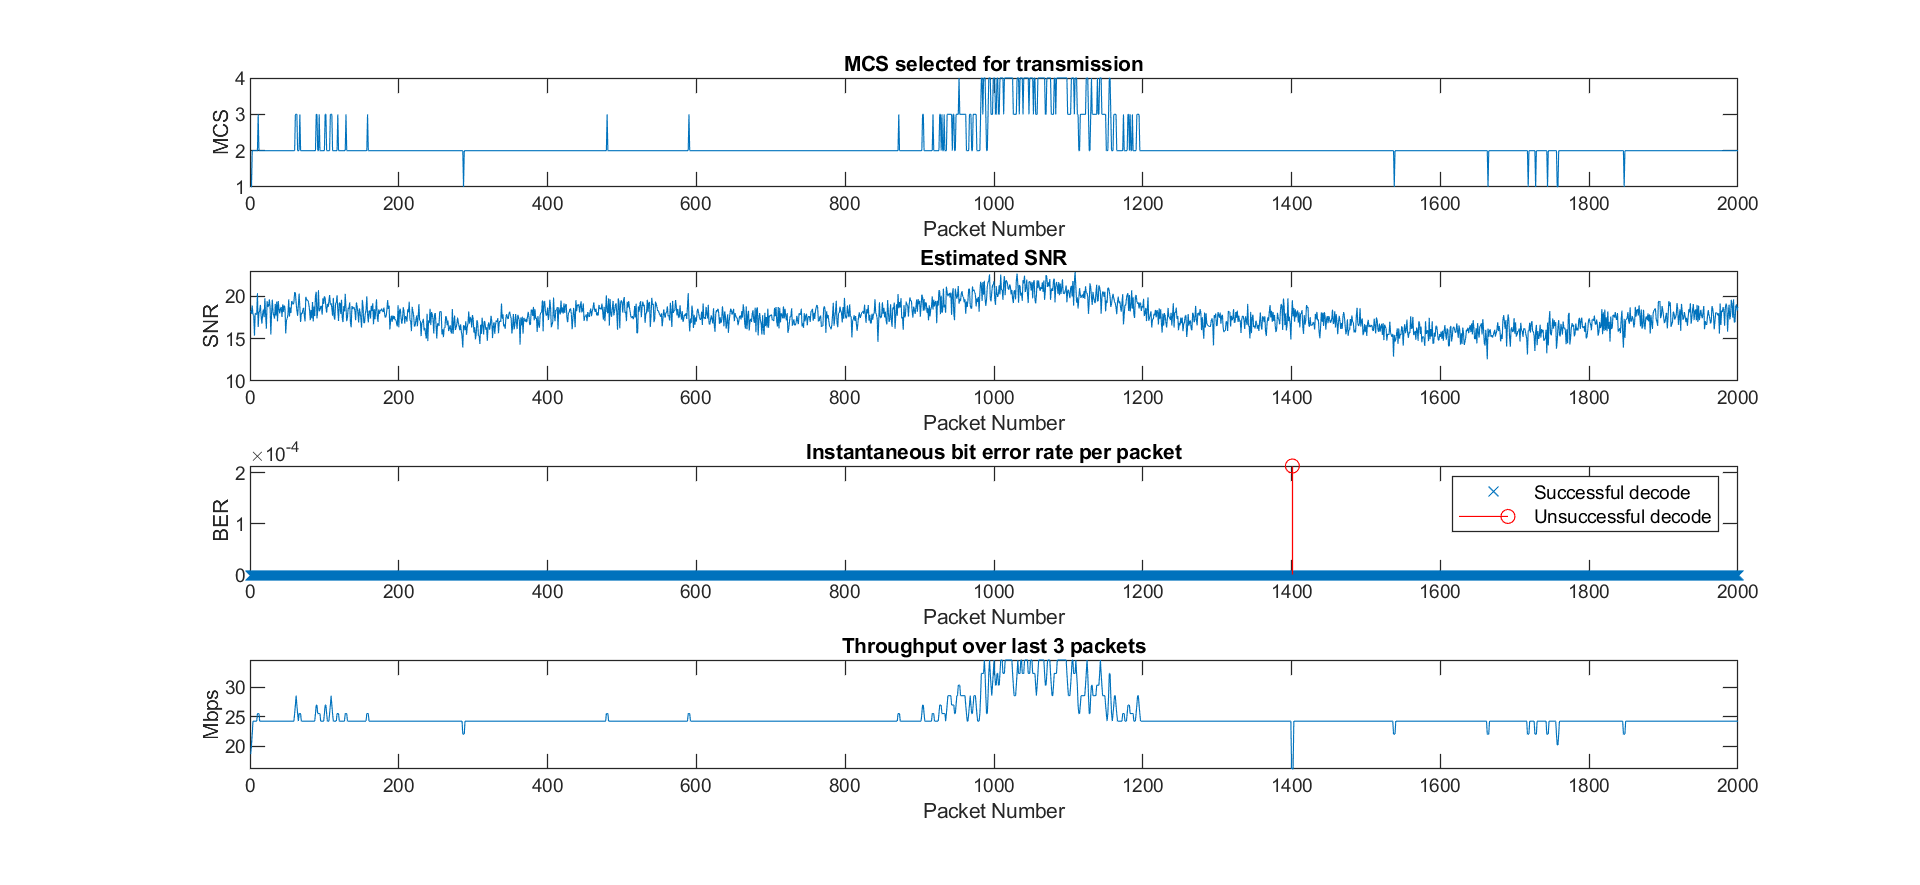
</div>


<div style="text-align: center;">
    <p><strong>Output variable snrwalk</strong></p>
    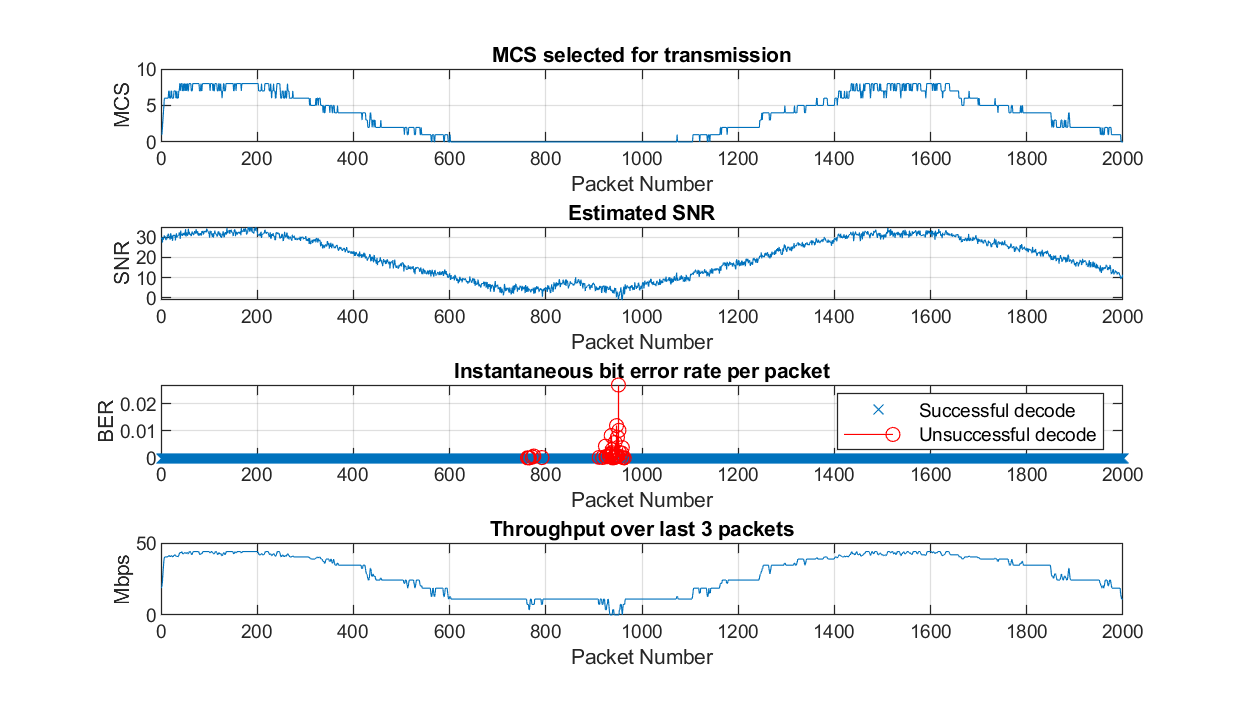
</div>


### *Note: For better clarity, watch [Dynamic rate control simulation in an 802.11ac channel](https://www.youtube.com/watch?v=aYrr04kZOmc) on CNI YouTube channel*

### *4. Code*

### Local Functions

The following local functions are used in this example:

- **Exp5_processPacket**: Adds channel impairments and decodes the received packet.
- **Exp5_plotResults**: Plots the simulation results.



In [2]:
%%file Exp5_processPacket.m

function Y = Exp5_processPacket(txWave,snrWalk,tgacChannel,cfgVHT)
    % Pass the transmitted waveform through the channel, perform
    % receiver processing, and SNR estimation.

    chanBW = cfgVHT.ChannelBandwidth; % Channel bandwidth
    % Set the following parameters to empty for an undetected packet
    estimatedSNR = [];
    eqDataSym = [];
    noiseVarVHT = [];
    rxPSDU = [];

    % Get the OFDM info
    ofdmInfo = wlanVHTOFDMInfo('VHT-Data',cfgVHT);

    % Pass the waveform through the fading channel model
    rxWave = tgacChannel(txWave);

    % Account for noise energy in nulls so the SNR is defined per
    % active subcarrier
    packetSNR = snrWalk-10*log10(ofdmInfo.FFTLength/ofdmInfo.NumTones);

    % Add noise
    rxWave = awgn(rxWave,packetSNR);
    rxWaveformLength = size(rxWave,1); % Length of the received waveform

    % Recover packet
    ind = wlanFieldIndices(cfgVHT); % Get field indices
    pktOffset = wlanPacketDetect(rxWave,chanBW); % Detect packet

    if ~isempty(pktOffset) % If packet detected
        % Extract the L-LTF field for fine timing synchronization
        LLTFSearchBuffer = rxWave(pktOffset+(ind.LSTF(1):ind.LSIG(2)),:);

        % Start index of L-LTF field
        finePktOffset = wlanSymbolTimingEstimate(LLTFSearchBuffer,chanBW);

        % Determine final packet offset
        pktOffset = pktOffset+finePktOffset;

        if pktOffset<15 % If synchronization successful
            % Extract VHT-LTF samples from the waveform, demodulate and
            % perform channel estimation
            VHTLTF = rxWave(pktOffset+(ind.VHTLTF(1):ind.VHTLTF(2)),:);
            demodVHTLTF = wlanVHTLTFDemodulate(VHTLTF,cfgVHT);
            [chanEstVHTLTF,chanEstSSPilots] = wlanVHTLTFChannelEstimate(demodVHTLTF,cfgVHT);

            % Extract VHT data field
            vhtdata = rxWave(pktOffset+(ind.VHTData(1):ind.VHTData(2)),:);

            % Estimate the noise power in VHT data field
            noiseVarVHT = vhtNoiseEstimate(vhtdata,chanEstSSPilots,cfgVHT);

            % Recover equalized symbols at data carrying subcarriers using
            % channel estimates from VHT-LTF
            [rxPSDU,~,eqDataSym] = wlanVHTDataRecover(vhtdata,chanEstVHTLTF,noiseVarVHT,cfgVHT);

            % SNR estimation per receive antenna
            powVHTLTF = mean(VHTLTF.*conj(VHTLTF));
            estSigPower = powVHTLTF-noiseVarVHT;
            estimatedSNR = 10*log10(mean(estSigPower./noiseVarVHT));
        end
    end

    % Set output
    Y = struct( ...
        'RxPSDU',           rxPSDU, ...
        'EqDataSym',        eqDataSym, ...
        'RxWaveformLength', rxWaveformLength, ...
        'NoiseVar',         noiseVarVHT, ...
        'EstimatedSNR',     estimatedSNR);

end

Created file 'C:\Users\kalya\Music\exp5\Exp5_processPacket.m'.


In [4]:
%%file 'Exp5_plotResults.m'

function Exp5_plotResults(ber,packetLength,snrMeasured,MCS,cfgVHT)
    % Visualize simulation results

    figure('Outerposition',[50 50 900 700])
    subplot(4,1,1);
    plot(MCS);
    xlabel('Packet Number')
    ylabel('MCS')
    title('MCS selected for transmission')

    subplot(4,1,2);
    plot(snrMeasured);
    xlabel('Packet Number')
    ylabel('SNR')
    title('Estimated SNR')

    subplot(4,1,3);
    plot(find(ber==0),ber(ber==0),'x')
    hold on; stem(find(ber>0),ber(ber>0),'or')
    if any(ber)
        legend('Successful decode','Unsuccessful decode')
    else
        legend('Successful decode')
    end
    xlabel('Packet Number')
    ylabel('BER')
    title('Instantaneous bit error rate per packet')

    subplot(4,1,4);
    windowLength = 3; % Length of the averaging window
    movDataRate = movsum(8*cfgVHT.APEPLength.*(ber==0),windowLength)./movsum(packetLength,windowLength)/1e6;
    plot(movDataRate)
    xlabel('Packet Number')
    ylabel('Mbps')
    title(sprintf('Throughput over last %d packets',windowLength))

end


Created file 'C:\Users\kalya\Music\exp5\Exp5_plotResults.m'.


### Waveform Configuration

- The simulation involves an IEEE 802.11ac VHT transmission.
- VHT waveform properties are specified using the `wlanVHTConfig` configuration object.
- Initial configuration includes:
  - **Channel Bandwidth**: 40 MHz.
  - **Transmit Antenna**: Single antenna.
  - **Modulation and Coding Scheme (MCS)**: QPSK rate-1/2 (MCS 1).
- The algorithm dynamically updates the MCS for subsequent packets during the simulation.


In [3]:
% 802.11 Dynamic Rate Control Simulation
% In this example, an IEEE 802.11ac™ [ 1 ] waveform consisting of a single VHT format packet is generated using the wlanWaveformGenerator function. 
% The waveform is passed through a TGac channel and noise is added. The packet is synchronized and decoded to recover the PSDU. 
% The SNR is estimated and compared against thresholds to determine which MCS is suitable for transmission of the next packet.

clc;
clear all;
cfgVHT = wlanVHTConfig;
cfgVHT.ChannelBandwidth = 'CBW40'; % 40 MHz channel bandwidth
cfgVHT.MCS = 1;                    % QPSK rate-1/2
cfgVHT.APEPLength = 4096;          % APEP length in bytes

% Set random stream for repeatability of results
s = rng(21);

### Channel Configuration

- The simulation uses a **TGac N-LOS channel model** with **delay profile Model-D**.
- **Model-D Characteristics**:
  - When the transmitter-receiver distance is **≥ 10 meters**, the channel model becomes **NLOS**.


In [5]:
tgacChannel = wlanTGacChannel;
tgacChannel.DelayProfile = 'Model-D';
tgacChannel.ChannelBandwidth = cfgVHT.ChannelBandwidth;
tgacChannel.NumTransmitAntennas = 1;
tgacChannel.NumReceiveAntennas = 1;
tgacChannel.TransmitReceiveDistance = 20; % Distance in meters for NLOS
tgacChannel.RandomStream = 'mt19937ar with seed';
tgacChannel.Seed = 0;
tgacChannel.NormalizeChannelOutputs = false;

% Set the sampling rate for the channel
sr = wlanSampleRate(cfgVHT);
tgacChannel.SampleRate = sr;

### Rate Control Algorithm Parameters

- **Rate Control Algorithm (RCA)** uses channel quality metrics like **SNR** or **packet error rate** for rate selection.
- In this example, the RCA **estimates the SNR** of a received packet.
- The **estimated SNR** is compared against a **predefined threshold**:
  - If the SNR exceeds the threshold, a new **MCS** is selected for the next packet.
  - The **rcaAttack** and **rcaRelease** parameters smooth rate changes:
    - The SNR must exceed **threshold + rcaAttack** to increase the MCS.
    - The SNR must be under **threshold - rcaRelease** to decrease the MCS.
- In this simulation:
  - **rcaAttack** and **rcaRelease** are set to **increase MCS conservatively** and **reduce it aggressively**.
  - For the selected **threshold** values, a small number of **packet errors** are expected.
  - These settings may not be suitable for other scenarios.


In [6]:
rcaAttack = 1;  % Control the sensitivity when MCS is increasing
rcaRelease = 0; % Control the sensitivity when MCS is decreasing
threshold = [11 14 19 20 25 28 30 31 35];
snrUp = [threshold inf]+rcaAttack;
snrDown = [-inf threshold]-rcaRelease;
snrInd = cfgVHT.MCS; % Store the start MCS value

### Simulation Parameters

- **numPackets**: Specifies the number of packets transmitted through a TGac channel, separated by a fixed idle time.
- **Channel state**: The channel state is maintained throughout the simulation, evolving slowly over time, which causes the resulting SNR at the receiver to change gradually.
- **SNR variation**: To observe SNR variation over a short simulation period, the **walkSNR** parameter is used to modify the noise power:
  - **walkSNR = true**: Generates varying SNR by randomly setting the noise power per packet during transmission. The SNR walks between **14-33 dB** (using the **amplitude** and **meanSNR** variables).
  - **walkSNR = false**: Fixes the noise power applied to the received waveform, allowing channel variations to be the main source of SNR changes at the receiver.


In [7]:
numPackets = 100; % Number of packets transmitted during the simulation
walkSNR = true;

% Select SNR for the simulation
if walkSNR
    meanSNR = 22;   % Mean SNR
    amplitude = 14; % Variation in SNR around the average mean SNR value
    % Generate varying SNR values for each transmitted packet
    baseSNR = sin(linspace(1,10,numPackets))*amplitude+meanSNR;
    snrWalk = baseSNR(1); % Set the initial SNR value
    % The maxJump controls the maximum SNR difference between one
    % packet and the next
    maxJump = 0.5;
else
    % Fixed mean SNR value for each transmitted packet. All the variability
    % in SNR comes from a time varying radio channel
    snrWalk = 22; %#ok<UNRCH>
end

% To plot the equalized constellation for each spatial stream set
% displayConstellation to true
displayConstellation = false;
if displayConstellation
    ConstellationDiagram = comm.ConstellationDiagram; %#ok<UNRCH>
    ConstellationDiagram.ShowGrid = true;
    ConstellationDiagram.Name = 'Equalized data symbols';
end

% Define simulation variables
snrMeasured = zeros(1,numPackets);
MCS = zeros(1,numPackets);
ber = zeros(1,numPackets);
packetLength = zeros(1,numPackets);

### Processing Chain

For each packet, the following processing steps occur:

- **PSDU Creation and Encoding**: A PSDU is created and encoded to form a single packet waveform.
- **Idle Time**: A fixed idle time is added between successive packets.
- **TGac Channel**: The waveform is passed through an evolving TGac channel.
- **AWGN Addition**: Additive White Gaussian Noise (AWGN) is added to the transmitted waveform to create the desired average SNR per subcarrier.
- **Packet Processing**: The local function **Exp5_processPacket** passes the transmitted waveform through the TGac channel, performs receiver processing, and estimates the SNR.
- **VHT-LTF Extraction**: The VHT-LTF (Long Training Field) is extracted from the received waveform, OFDM demodulated, and channel estimation is performed.
- **VHT Data Extraction**: The VHT Data field is extracted from the synchronized received waveform.
- **Noise Estimation**: Noise estimation is performed using the demodulated data field pilots and single-stream channel estimate at pilot subcarriers.
- **SNR Comparison**: The estimated SNR for each packet is compared against the threshold. This comparison is used to adjust the MCS for the next packet.
- **PSDU Recovery**: The PSDU is recovered using the extracted VHT-Data field.

### Assumptions for Simplicity

- **Fixed Bandwidth and Antenna Configuration**: Each transmitted packet uses a fixed bandwidth and antenna configuration.
- **No Feedback Packet**: There is no explicit feedback packet to inform the transmitter about the suggested MCS setting for the next packet. The transmitter is assumed to know this information before transmitting the next packet.
- **Fixed Idle Time**: A fixed idle time of **0.5 milliseconds** is assumed between packets.


In [8]:
for numPkt = 1:numPackets
    if walkSNR
        % Generate SNR value per packet using random walk algorithm biased
        % towards the mean SNR
        snrWalk = 0.9*snrWalk+0.1*baseSNR(numPkt)+rand(1)*maxJump*2-maxJump;
    end

    % Generate a single packet waveform
    txPSDU = randi([0,1],8*cfgVHT.PSDULength,1,'int8');
    txWave = wlanWaveformGenerator(txPSDU,cfgVHT,'IdleTime',5e-4);

    % Receive processing, including SNR estimation
    y = Exp5_processPacket(txWave,snrWalk,tgacChannel,cfgVHT);

    % Plot equalized symbols of data carrying subcarriers
    if displayConstellation && ~isempty(y.EstimatedSNR)
        release(ConstellationDiagram);
        ConstellationDiagram.ReferenceConstellation = wlanReferenceSymbols(cfgVHT);
        ConstellationDiagram.Title = ['Packet ' int2str(numPkt)];
        ConstellationDiagram(y.EqDataSym(:));
        drawnow
    end

    % Store estimated SNR value for each packet
    if isempty(y.EstimatedSNR)
        snrMeasured(1,numPkt) = NaN;
    else
        snrMeasured(1,numPkt) = y.EstimatedSNR;
    end

    % Determine the length of the packet in seconds including idle time
    packetLength(numPkt) = y.RxWaveformLength/sr;

    % Calculate packet error rate (PER)
    if isempty(y.RxPSDU)
        % Set the PER of an undetected packet to NaN
        ber(numPkt) = NaN;
    else
        [~,ber(numPkt)] = biterr(y.RxPSDU,txPSDU);
    end

    % Compare the estimated SNR to the threshold, and adjust the MCS value
    % used for the next packet
    MCS(numPkt) = cfgVHT.MCS; % Store current MCS value
    increaseMCS = (mean(y.EstimatedSNR) > snrUp((snrInd==0)+snrInd));
    decreaseMCS = (mean(y.EstimatedSNR) <= snrDown((snrInd==0)+snrInd));
    snrInd = snrInd+increaseMCS-decreaseMCS;
    cfgVHT.MCS = snrInd-1;
end

### Display and Plot Simulation Results

This example plots the variation of MCS, SNR, BER, and data throughput over the duration of the simulation.

- **MCS Plot**: The MCS (Modulation and Coding Scheme) used to transmit each packet is plotted. When compared to the estimated SNR, it can be observed that the MCS selection depends on the estimated SNR.
- **Bit Error Rate (BER)**: The bit error rate per packet is influenced by channel conditions, SNR, and the MCS used for transmission.
- **Throughput Calculation**: Throughput is maximized by varying the MCS according to channel conditions. It is calculated using a sliding window of three packets. For each point plotted:
  - Throughput is the number of data bits successfully recovered over the duration of three packets.
  - The length of the sliding window can be increased to further smooth the throughput curve.
  - Drops in throughput occur when the MCS decreases or when packet errors occur.


Overall data rate: 20.631 Mbps
Overall packet error rate: 0.03



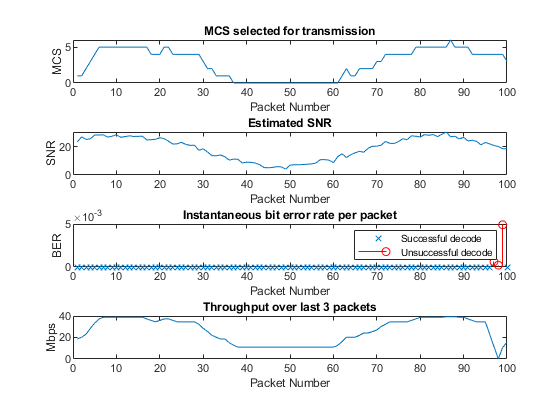

In [9]:
% Display and plot simulation results
disp(['Overall data rate: ' num2str(8*cfgVHT.APEPLength*(numPackets-numel(find(ber)))/sum(packetLength)/1e6) ' Mbps']);
disp(['Overall packet error rate: ' num2str(numel(find(ber))/numPackets)]);

Exp5_plotResults(ber,packetLength,snrMeasured,MCS,cfgVHT);

% Restore default stream
rng(s);